Imports

In [1]:
%matplotlib inline

import matplotlib.pyplot as plt
import torch
import CNN

# from config_plots import global_settings
# global_settings()
import warnings
warnings.filterwarnings("ignore")

Hyper parameters

In [2]:
# defining global variables
experimentName = "test_22987_suffix50_11_dataLoader3_heirarchy_cleaned_no_relu_resnet18"

from configParser import ConfigParser
params = ConfigParser(experimentName).read()
print(params)

import os
experimentName = os.path.join(experimentName, "single-trial")
import TrialStatistics
ts = TrialStatistics.TrialStatistics(experimentName)

import dataLoader3 as dataLoader 

{'image_path': '/data/BGNN_data/INHS_cropped', 'suffix': '50_11', 'training_count': 0.64, 'validation_count': 0.16, 'useHeirarchy': True, 'imageDimension': 224, 'n_channels': 3, 'batchSize': 200, 'n_epochs': 1000, 'learning_rate': 0.001, 'numOfTrials': 2, 'patience': 100}


Cuda support

In [3]:
# CUDA support 
if torch.cuda.is_available():
    torch.cuda.set_device(0) # 0
    torch.set_default_tensor_type('torch.cuda.FloatTensor')
    print("We are using cuda")

We are using cuda


Load images

In [4]:
import torchvision

# load images
datasetManager = dataLoader.datasetManager(experimentName, True)
datasetManager.updateParams(params)
dataset = datasetManager.getDataset()
speciesList = dataset.getSpeciesList()
numberOfSpecies = len(speciesList)
print('species:', speciesList)
print("Number of species = ", numberOfSpecies)
genusList = dataset.getGenusList()
numberOfGenus = len(genusList)
print('genus:', genusList)
print("Number of species = ", numberOfGenus)

N/A% (0 of 550) |                        | Elapsed Time: 0:00:00 ETA:  --:--:--

Loading dataset...


  0% (4 of 550) |                        | Elapsed Time: 0:00:00 ETA:   0:00:15

Going through image files


100% (550 of 550) |######################| Elapsed Time: 0:00:45 Time:  0:00:45


dataset has a mean: tensor([0.4145, 0.3889, 0.3449]) and std: tensor([0.3050, 0.3047, 0.2991])
file /data/BGNN_data/INHS_cropped/50_11/test_22987_suffix50_11_dataLoader3_heirarchy_cleaned_no_relu_resnet18/single-trial/tc0.640000_vc0.160000_d224_c3/dataset.pkl written
species: ['Lepomis cyanellus', 'Lepomis auritus', 'Carassius auratus', 'Cyprinus carpio', 'Esox americanus', 'Esox lucius', 'Noturus gyrinus', 'Noturus exilis', 'Noturus flavus', 'Noturus eleutherus', 'Noturus insignis']
Number of species =  11
genus: ['Lepomis', 'Carassius', 'Cyprinus', 'Esox', 'Noturus']
Number of species =  5


Create/Load model

In [5]:
import os

architecture = {
    "species": numberOfSpecies,
    "genus" : numberOfGenus
}
model = CNN.create_model(architecture, params)

train_loader, validation_loader, test_loader = datasetManager.getLoaders()
if os.path.exists(CNN.getModelFile(experimentName)):
    loss_list, accuracy_list, epochs, time_elapsed = CNN.loadModel(model, experimentName)
    print("Model {0} loaded!".format(experimentName))
else:
    loss_list, accuracy_list, epochs, time_elapsed = CNN.trainModel(train_loader, validation_loader, params, model, experimentName)

file /data/BGNN_data/INHS_cropped/50_11/test_22987_suffix50_11_dataLoader3_heirarchy_cleaned_no_relu_resnet18/single-trial/trainingIndex.pkl written
file /data/BGNN_data/INHS_cropped/50_11/test_22987_suffix50_11_dataLoader3_heirarchy_cleaned_no_relu_resnet18/single-trial/valIndex.pkl written
file /data/BGNN_data/INHS_cropped/50_11/test_22987_suffix50_11_dataLoader3_heirarchy_cleaned_no_relu_resnet18/single-trial/testIndex.pkl written
file /data/BGNN_data/INHS_cropped/50_11/test_22987_suffix50_11_dataLoader3_heirarchy_cleaned_no_relu_resnet18/single-trial/tc0.640000_vc0.160000_d224_c3/trainingLoader.pkl written
file /data/BGNN_data/INHS_cropped/50_11/test_22987_suffix50_11_dataLoader3_heirarchy_cleaned_no_relu_resnet18/single-trial/tc0.640000_vc0.160000_d224_c3/valLoader.pkl written


N/A% (0 of 1000) |                       | Elapsed Time: 0:00:00 ETA:  --:--:--

file /data/BGNN_data/INHS_cropped/50_11/test_22987_suffix50_11_dataLoader3_heirarchy_cleaned_no_relu_resnet18/single-trial/tc0.640000_vc0.160000_d224_c3/testLoader.pkl written
Training started...


100% (1000 of 1000) |####################| Elapsed Time: 4:55:49 Time:  4:55:49


Early stopping
total number of epochs:  405


Plot

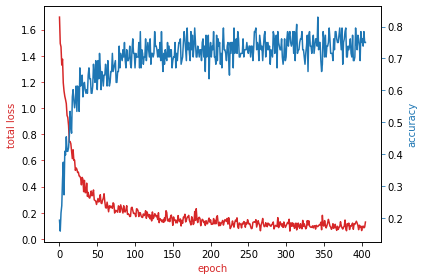

In [6]:
# Plot the loss and accuracy

fig, ax1 = plt.subplots()
color = 'tab:red'
ax1.plot(loss_list, color=color)
ax1.set_xlabel('epoch', color=color)
ax1.set_ylabel('total loss', color=color)
ax1.tick_params(axis='y', color=color)
    
ax2 = ax1.twinx()  
color = 'tab:blue'
ax2.set_ylabel('accuracy', color=color)  
ax2.plot(accuracy_list, color=color)
ax2.tick_params(axis='y', color=color)
fig.tight_layout()

Create confusion matrix

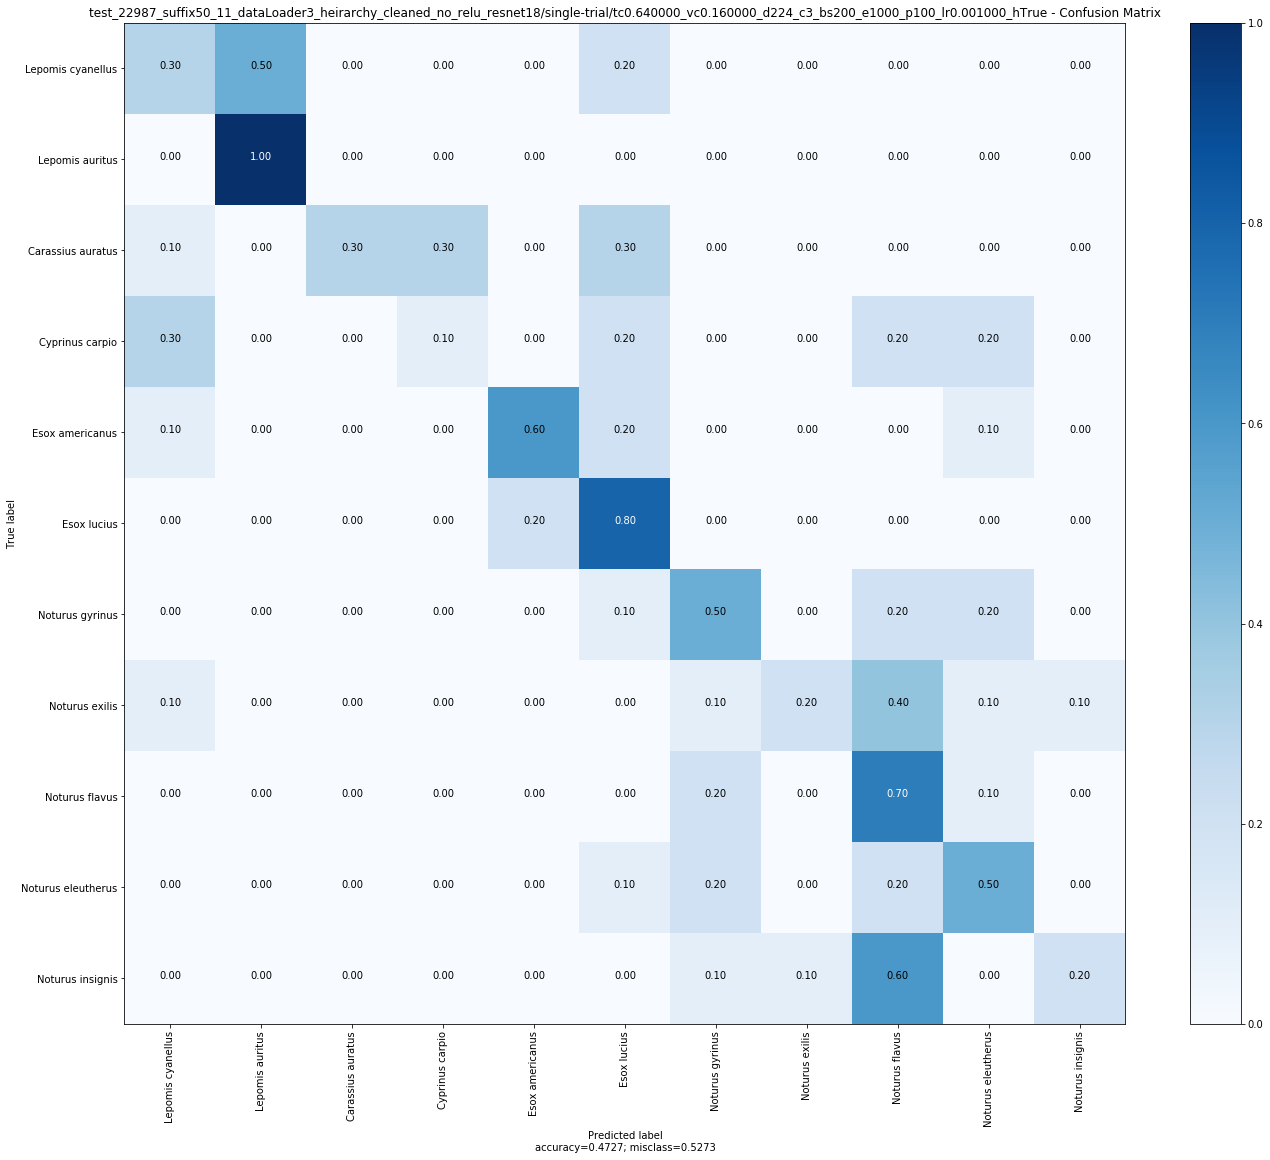

Macro f1: 0.44626716845822595
Weighted macro f1: 0.446267168458226
Micro f1: 0.4727272727272727


In [7]:
predlist, lbllist = CNN.getLoaderPredictions(test_loader, model, params)
ts.addTrialPredictions(params, predlist, lbllist, numberOfSpecies)
conf_mat = ts.printTrialConfusionMatrix(params, speciesList, True)

from sklearn.metrics import f1_score
print("Macro f1:", f1_score(lbllist.cpu(), predlist.cpu(), average='macro'))
print("Weighted macro f1:", f1_score(lbllist.cpu(), predlist.cpu(), average='weighted'))
print("Micro f1:", f1_score(lbllist.cpu(), predlist.cpu(), average='micro'))

Precision/Recall/Fscore

In [8]:
ts.addTrial(params,
            {'loss': CNN.getCrossEntropyFromLoader(test_loader, model, params),
             'accuracy': CNN.getAccuracyFromLoader(test_loader, model, params),
             'time': time_elapsed,
             'epochs': epochs
            })


IndexError: Dimension out of range (expected to be in range of [-1, 0], but got 1)

In [ ]:
ts.showStatistics()
ts.saveStatistics()

In [ ]:
ts.showStatistics(False)
ts.saveStatistics(False)

Plot parameters of first layer

In [ ]:
import PlotNetwork
PlotNetwork.plot_channels(model, 0, experimentName)

Plot parameters of second layer

In [ ]:
# PlotNetwork.plot_channels(model, -8, experimentName)

Plot activations

In [ ]:
# Which example you want to plot for?
exampleId = 90


shape = dataset[exampleId]['image'].shape
input_img = dataset[exampleId]['image'].view(1, shape[0], shape[1], shape[2])

PlotNetwork.plot_activations(model, 2, input_img, experimentName, "Genus Activations", 10)

In [ ]:
out = model(input_img)
useHeirarchy = params["useHeirarchy"]
if useHeirarchy:
    out = out["species"]

true_example_label = torch.max(out.data, 1)[1].item()
print("True label", true_example_label, dataset.getSpeciesOfIndex(true_example_label))
PlotNetwork.plot_activations(model, -1, input_img, experimentName, "Output of model", 10)

Least confused classes

In [ ]:
import numpy as np
import math

# From the confusion matrix, find the diagonal entries that have high value.
SuccessThreshold = 0.8

cm = conf_mat.astype('float') / conf_mat.sum(axis=1)[:, np.newaxis]
diagIndices = di = np.diag_indices(cm.shape[0])
conf_mat_diagValues = cm[diagIndices]

goodMatches = [i for i,v in enumerate(conf_mat_diagValues) if v >= SuccessThreshold]
goodMatches_count = len(goodMatches)

# Plot
n_channels = params["n_channels"]
number_per_row = 4
n_rows = math.ceil(goodMatches_count/number_per_row)
fig, axes = plt.subplots(n_rows, number_per_row, figsize=(15, 2.5*n_rows), dpi= 300)
out_index = 0
in_index = 0
for i, ax in enumerate(axes.flat):
    if i < goodMatches_count:
        index = goodMatches[i]
        speciesName = dataset.getSpeciesOfIndex(index)
        ax.set_xlabel("Class: {0}\n score: {1}".format(speciesName, conf_mat_diagValues[index]))

        # Plot the image.
        dataset.toggle_get_original()
        speciesExamples = dataset.getSpeciesIndices(speciesName)
        speciesExample = dataset[speciesExamples[0]]['image'].squeeze()
        dataset.toggle_get_original()

        if n_channels != 1:
            speciesExample = speciesExample.permute(1, 2, 0)
        ax.imshow(speciesExample.cpu().detach().numpy())
        ax.set_xticks([])
        ax.set_yticks([])
    else:
        break
        
fig.suptitle("Least confused classes")
fig.tight_layout(rect=[0, 0.03, 1, 0.95])
fig.show()
fig.savefig(os.path.join(experimentName,"LestConfusedClasses.pdf"))
    
    

Most confused classes

In [ ]:
# From the confusion matrix, find the diagonal entries that have high value.
ConfusionThreshold = 0.3

cm = conf_mat.astype('float') / conf_mat.sum(axis=1)[:, np.newaxis]
diagIndices = di = np.diag_indices(cm.shape[0])

goodMatches = [(x, y) for (x, y), v in np.ndenumerate(cm) if v >= ConfusionThreshold and x != y]
goodMatches_count = len(goodMatches)

number_per_row = 4
n_rows = math.ceil(goodMatches_count/number_per_row)
if n_rows >0:
    fig, axes = plt.subplots(n_rows, number_per_row, figsize=(15, 2.5*n_rows), dpi= 300)
    out_index = 0
    in_index = 0
    for i, ax in enumerate(axes.flat):
        if i < goodMatches_count:
            (x, y) = goodMatches[i]
            speciesNameConfused = dataset.getSpeciesOfIndex(x)
            speciesNameConfusedAs = dataset.getSpeciesOfIndex(y)
            ax.set_xlabel("{0} \n confused as \n{1}\n score: {2}".format(speciesNameConfused, speciesNameConfusedAs, cm[x][y]))

            # Plot the image.
            dataset.toggle_get_original()
            confusedSpeciesExamples = dataset.getSpeciesIndices(speciesNameConfused)
            confusedSpeciesExample = dataset[confusedSpeciesExamples[0]]['image'].squeeze()
            confusedAsSpeciesExamples = dataset.getSpeciesIndices(speciesNameConfusedAs)
            confusedAsSpeciesExample = dataset[confusedAsSpeciesExamples[0]]['image'].squeeze()
            dataset.toggle_get_original()

            channel = 2 if n_channels != 1 else 1
            stitchedImage = torch.cat((confusedSpeciesExample, confusedAsSpeciesExample), channel)

            if n_channels != 1:
                stitchedImage = stitchedImage.permute(1, 2, 0)
            ax.imshow(stitchedImage.cpu().detach().numpy())
            ax.set_xticks([])
            ax.set_yticks([])
        else:
            break

    fig.suptitle("Most confused classes")
    fig.tight_layout(rect=[0, 0.03, 1, 0.95])
    fig.show()
    fig.savefig(os.path.join(experimentName,"MostConfusedClasses.pdf"))

###### 